In [1]:
def load_data_from_file(
    data_path,
    label_text_path=None,
    split_sep="\t",
    maxsplit=-1,
    text_pos=1,
    label_pos=0,
    return_dict=True,
):
    """Parse a tab-separated text file to a CSR label matrix and a list of text strings.

    Text format for each line:
    <comma-separated label indices><TAB><space-separated text string>
    Example: l_1,..,l_k<TAB>w_1 w_2 ... w_t
        l_k can be one of two format:
            (1) the zero-based index for the t-th relevant label
            (2) double colon separated label index and label relevance
        w_t is the t-th token in the string

    Args:
        data_path (str): Path to the text file
        label_text_path (str, optional): Path to the label text file.
            The main purpose is to obtain the number of labels. Default: None
        split_sep (str, optional): The separator. Default: "\t".
        maxsplit (int, optional): The max number of splits for each line. Default: -1 to denote full split
        text_pos (int, optional): The position of the text part in each line. Default: 1.
        label_pos (int, optional): The position of the text part in each line. Default: 0.
        return_dict (bool, optional): if True, return the parsed results in a dictionary. Default True

    Returns:
        if return_dict:
            {
                "label_matrix": (csr_matrix) label matrix with shape (N, L),
                "label_relevance": (csr_matrix) label relevance matrix with shape (N, L)
                                    have same sparsity pattern as label_matrix.
                "corpus": (list of str) the parsed instance text with length N.
            }
        else:
            (label_matrix, label_relevance, corpus)
    """
    if not os.path.isfile(data_path):
        raise FileNotFoundError(f"cannot find input text file at {data_path}")
    with open(data_path, "r", encoding="utf-8") as fin:
        label_strings, corpus = [], []
        for line in fin:
            parts = line.strip("\n")
            parts = parts.split(split_sep, maxsplit)
            if len(parts) < max(label_pos, text_pos) + 1:
                raise ValueError(f"corrupted line from input text file:\n{line}")
            label_strings.append(parts[label_pos])
            text_string = parts[text_pos]
            corpus.append(text_string)

    def parse_label_strings(label_strings, L):
        rows, cols, vals, rels = [], [], [], []

        # determine if relevance is provided
        has_rel = ":" in label_strings[0]

        for i, label in enumerate(label_strings):
            if has_rel:
                label_tuples = [tp.split(":") for tp in label.split(",")]
                label_list = list(map(int, [tp[0] for tp in label_tuples]))
                # label values are currently not being used.
                val_list = list(map(float, [tp[1] if tp[1] else 1.0 for tp in label_tuples]))
                rel_list = list(map(float, [tp[2] for tp in label_tuples]))
            else:
                label_list = list(map(int, label.split(",")))
                val_list = [1.0] * len(label_list)
                rel_list = []

            rows += [i] * len(label_list)
            cols += label_list
            vals += val_list
            rels += rel_list

        Y = smat.csr_matrix(
            (vals, (rows, cols)), shape=(len(label_strings), L), dtype=np.float32
        )
        if has_rel:
            R = smat.csr_matrix(
                (rels, (rows, cols)), shape=(len(label_strings), L), dtype=np.float32
            )
        else:
            R = None

        return Y, R

    if label_text_path is not None:
        if not os.path.isfile(label_text_path):
            raise FileNotFoundError(f"cannot find label text file at: {label_text_path}")
        # this is used to obtain the total number of labels L to construct Y with a correct shape
        L = sum(1 for line in open(label_text_path, "r", encoding="utf-8") if line)
        label_matrix, label_relevance = parse_label_strings(label_strings, L)
    else:
        label_matrix = None
        label_relevance = None

    if return_dict:
        return {
            "label_matrix": label_matrix,
            "label_relevance": label_relevance,
            "corpus": corpus,
        }
    else:
        return label_matrix, label_relevance, corpus

In [43]:
import numpy as np
import pandas as pd
import os
from ogb.nodeproppred import PygNodePropPredDataset
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.utils import degree, to_undirected
from transformers import BertTokenizer
import pickle
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from multiprocessing.pool import ThreadPool
import statsmodels.api as sm
import pylab as py


data_name = 'arxiv'

dataset = PygNodePropPredDataset(name = f'ogbn-{data_name}', root='../data') 

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
data = dataset[0] # pyg graph object

if data_name == 'arxiv':
    map_classID_className = pd.merge(left=pd.read_csv("../data/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz", index_col=0), 
                                     right=pd.read_csv("../data/ogbn_arxiv/mapping/category_name.csv", index_col=0), 
                                     how='left', 
                                     left_on='arxiv category', 
                                     right_on='arxiv category').drop('arxiv category', axis=1)\
                            .rename(columns={"arxiv category name": "category"})\
                            .squeeze()
elif data_name == "products":
    map_classID_className = pd.read_csv("../data/ogbn_products/mapping/labelidx2productcategory.csv.gz", index_col=0)\
                            .rename(columns={"product category": "category"})\
                            .squeeze()

In [44]:
from collections import defaultdict


runs = 10

experiment_dir = "../experiments"

y_true = data.y[test_idx]
compare_df = pd.DataFrame({"y_true": y_true.flatten()})
class_freq_dict = pd.Series(data.y.flatten()).value_counts(normalize=True)
compare_df["class_freq"] = [class_freq_dict.loc[i] for i in compare_df["y_true"]]
compare_df["y_true"] = compare_df["y_true"].apply(lambda x: map_classID_className.loc[x])
X_text = load_data_from_file(
    f"../data/proc_data_multi_task/ogbn-{data_name}/X.all.txt",
    label_text_path=None,
    text_pos=0,
)["corpus"]
X_text = [X_text[i] for i in test_idx]
compare_df["X_text"] = X_text
compare_df["node_degrees"] = degree(to_undirected(data.edge_index)[0])[test_idx]
compare_df["same_neighbor(%)"] = np.load(f"final_{data_name}.npy")
compare_df.index = test_idx.numpy()

# with open(f'count_tokens_{data_name}.pickle', 'rb') as handle:
#     count_tokens = pickle.load(handle)
# compare_df["text_length"] = [count_tokens[i] for i in test_idx]

def combine_results(x, y):
    if x == y and x == True:
        return True
    elif x == y and x == False:
        return False
    else:
        return float("nan")

for run in range(0, runs):
    # Extract the predictions
    my_pred_dir = f"{experiment_dir}/{data_name}_sbert/run{run}"
    for file in os.listdir(my_pred_dir):
        # Get predictions from e2e model and ensemble predictions over runs
        filename = os.fsdecode(file)
        if filename.endswith("prediction_mclass"):
            compare_df["my_pred"] = np.load(f"{my_pred_dir}/{filename}").argmax(axis=1)
            
    bert_pred_dir = f"{experiment_dir}/bert_classifier_{data_name}/run{run}"
    for file in os.listdir(bert_pred_dir):
        # Get predictions from bert model and ensemble predictions over runs
        filename = os.fsdecode(file)
        if filename.endswith(".npy"):
            compare_df["bert_pred"] = np.load(f"{bert_pred_dir}/{filename}")
            
    giant_pred_dir = f"{experiment_dir}/giant_original_{data_name}/run{run}"
    for file in os.listdir(giant_pred_dir):
        # Get predictions from bert model and ensemble predictions over runs
        filename = os.fsdecode(file)
        if filename.endswith(".npy"):
            compare_df["giant_pred"] = np.load(f"{giant_pred_dir}/{filename}").flatten()[test_idx]
    
    # Convert idx to name and combine over runs
    for pred in ["my_pred", "bert_pred", "giant_pred"]:
        # Replace category index with category name
        compare_df[pred] = compare_df[pred].apply(lambda x: map_classID_className.loc[x])
        if run == 0:
            # Whether each prediction is correct. 
            compare_df[pred + "_correct"] = compare_df[pred] == compare_df["y_true"]
        else:
            # Combine for multiple runs. 
            # Correct if all runs are correct
            # Wrong if all runs are wrong
            # Otherwise discard, bc it depends on randomness
            compare_df[pred + "_correct"] = [combine_results(x, y) 
                                             for x,y in zip(compare_df[pred] == compare_df["y_true"].tolist(),
                                                            compare_df[pred + "_correct"].tolist())]
compare_df = compare_df.dropna()
compare_df = compare_df.astype({'my_pred_correct': 'bool', 'bert_pred_correct': 'bool', 'giant_pred_correct': 'bool'})



# Add percentage of neighbors that has the same class
adj = to_scipy_sparse_matrix(to_undirected(data.edge_index))
def get_neightbors(node):
    return adj.getrow(node).indices

# def get_percentage_same_neighbor(node):
#     neighbors_classes = data.y[get_neightbors(node)]
#     node_class = data.y[node]
#     return np.count_nonzero(neighbors_classes == node_class) / len(neighbors_classes)

# def save_percentage_same_neighbor_chunk(start_id, end_id):
#     nodes = test_idx[start_id:end_id]
#     np.save(f"{start_id}_{end_id-1}.npy", np.array([get_percentage_same_neighbor(node) for node in nodes]))

# chunk=5000
# futures = []
# pool = ThreadPool(7)
# for i in range(0,  compare_df.shape[0], chunk):
#     futures.append(pool.apply_async(save_percentage_same_neighbor_chunk, (i, min(i+chunk, compare_df.shape[0])))) 
# pool.close()
# pool.join()
# for future in futures:
#     future.get()

# combine = []
# for i in range(0,  compare_df.shape[0], chunk):
#     combine.append(np.load(f"{i}_{min(i+chunk-1, compare_df.shape[0]-1)}.npy"))
# compare_df["same_neighbor(%)"] = np.concatenate(combine)

compare_df.to_csv(f"compare_df_{data_name}.csv")

# compare_df = pd.read_csv(f"compare_df_{data_name}.csv")

In [45]:
result_dict = {"e2e_wrong": ((compare_df["my_pred_correct"]==False)),
"all_correct": ((compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"bert_correct_only": (~(compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"giant_correct_only": (~(compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"e2e_correct_only": ((compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"all_wrong": (~(compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"e2e_correct_bert_wrong": ((compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)),
"e2e_correct_giant_wrong": ((compare_df["my_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"e2e_wrong_bert_correct": (~(compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)),
"e2e_wrong_giant_correct": (~(compare_df["my_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"e2e_correct_bert_correct": ((compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)),
"e2e_correct_giant_correct": ((compare_df["my_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"all": np.full((compare_df.shape[0],), True)
}

print("Dropped samples: ", 100 - compare_df.shape[0] / test_idx.shape[0] * 100)


Dropped samples:  33.46396510581806


### E2E wrong

In [46]:
df = compare_df[result_dict['all_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', "giant_pred_correct", 'y_true', "class_freq"]]


In [47]:
compare_df[result_dict['all_wrong']][["same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].head()


,same_neighbor(%),my_pred,bert_pred,y_true,class_freq,node_degrees
235939,0.990909,Books,Industrial & Scientific,Automotive,0.034134,110.0
235967,0.854167,Baby Products,Health & Personal Care,Baby,0.013271,48.0
235975,0.148148,Home & Kitchen,Home & Kitchen,"Patio, Lawn & Garden",0.016625,81.0
235980,0.363636,Baby Products,Sports & Outdoors,Baby,0.013271,22.0
235986,0.666667,CDs & Vinyl,CDs & Vinyl,Books,0.273149,3.0


In [52]:
pd.set_option('display.max_colwidth', None)
central_node = 235975
compare_df[result_dict['all_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].loc[central_node]

X_text              chill it - wine bag beer bottle cooler & ice chiller freezable carrier (violet) sleek, contemporary and cool - the new freezable chill bags have been a huge hit! keep these bags in the freezer and they become instant coolers for not only wine, but champagne, vodkas, beer, or whatever other beverages you want to keep chilled. there are six bold, eye-catching colors to choose from. these cosmopolitan bags are festive, fun, and make for unique gift items. please do not forget to reuse them. show up at your hosts or party with this beautiful classy and cool bag, moreover your wine will arrive chilled and ready to serve.....
same_neighbor(%)                                                                                                                                                                                                                                                                                                                                                

In [50]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx, is_undirected, to_undirected, k_hop_subgraph, subgraph
from collections import defaultdict
import matplotlib.cm as cm
from matplotlib.colors import Normalize

num_hops=2

edge_index = data.edge_index
if not is_undirected(edge_index):
    edge_index = to_undirected(edge_index)
Degree = degree(edge_index[0])
Filtered_idx = torch.where(Degree < 300)[0]

edge_index, _ = subgraph(Filtered_idx, edge_index=edge_index)

node_subset, edge_index, _, _ = k_hop_subgraph(node_idx=central_node,   # torch.tensor(df.index.values),
                                                       num_hops=num_hops,
                                                       edge_index=edge_index)


    
G = nx.MultiGraph()
G.add_nodes_from(list(node_subset.numpy()))
G.add_edges_from([tuple(x) for x in edge_index.t().numpy()])


len(node_subset)


1995

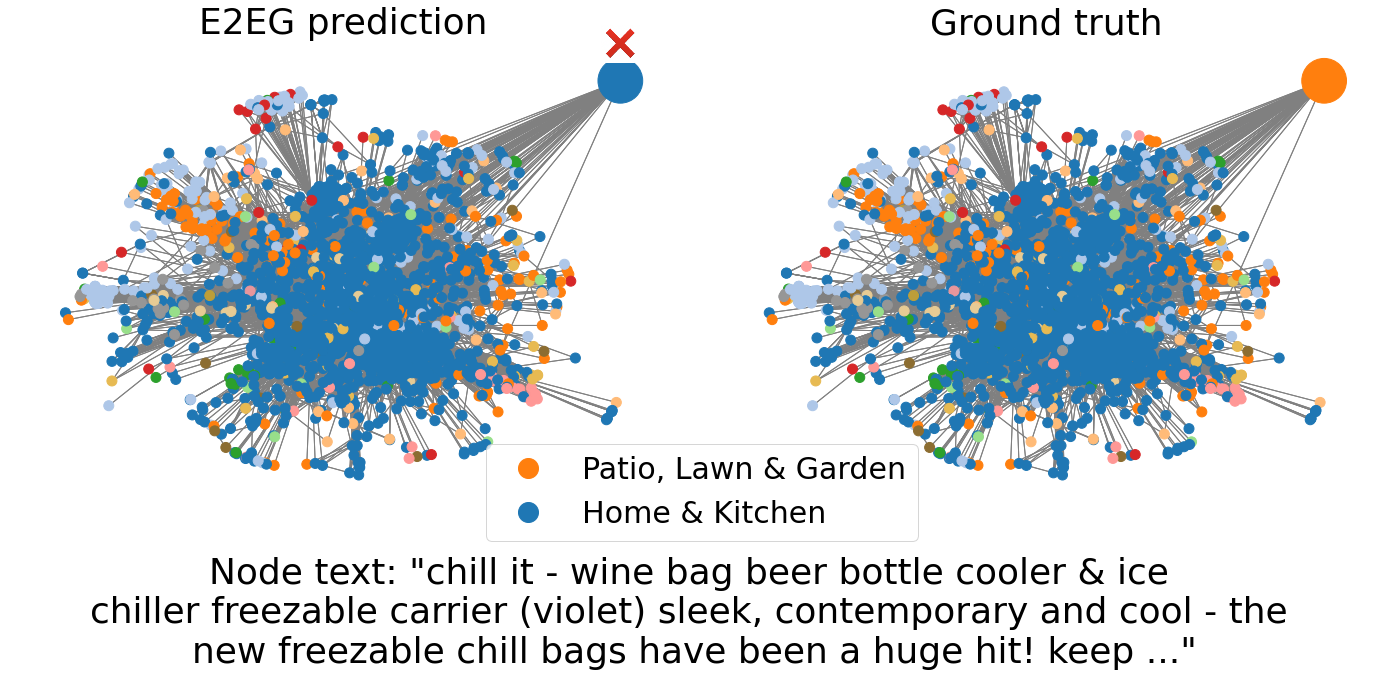

In [57]:
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.rcParams.update({'font.size': 30})

nr_classes = data.y.max().numpy() + 1
cmap1 = cm.get_cmap("tab20")
cmap2 = cm.get_cmap("tab20b")
cmap3 = cm.get_cmap("tab20c")
norm = Normalize(vmin=0, vmax=nr_classes)
d1 = {node_class: cmap1(norm(node_class)) for node_class in range(0, 20)}
d2 = {node_class: cmap2(norm(node_class)) for node_class in range(20, 40)}
d3 = {node_class: cmap3(norm(node_class)) for node_class in range(40, nr_classes)}

color_map_all = {**d1, **d2, **d3}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(f'Node text: \"{" ".join(compare_df.loc[central_node, "X_text"].split()[:10])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[10:20])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[20:30])} ...\"', 
             y=-0.01)
np.random.seed(1)

normal_node_size = 100
node_sizes = np.ones((node_subset.shape[0],) ) * normal_node_size
node_sizes[np.where(node_subset.numpy() == central_node)[0][0]] = normal_node_size*20


color_map_ytrue = [color_map_all[x] for x in data.y[node_subset.numpy()].numpy().flatten()]
color_map_mine = [color_map_all[x] for x in data.y[node_subset.numpy()].numpy().flatten()]
color_map_mine[np.where(node_subset.numpy() == central_node)[0][0]] = \
        color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]]

center_loc = np.array([1,1])

pos=nx.spring_layout(G)
pos[central_node] = center_loc


nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_mine, ax=ax1)
nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_ytrue, ax=ax2)
ax1.set_title("E2EG prediction")
ax2.set_title("Ground truth")

# reading the image
correct = plt.imread('../visualization/analysis/correct.png')
wrong = plt.imread('../visualization/analysis/wrong.png')
# OffsetBox
correct_box = OffsetImage(correct, zoom=0.3)
wrong_box = OffsetImage(wrong, zoom=0.3)

ab = AnnotationBbox(wrong_box, center_loc + np.array([0, 0.17]), frameon=False)
ax1.add_artist(ab)


legend_elements = [Line2D([0], [0], marker='o', color=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "y_true"]].index[0]], 
                          label=compare_df.loc[central_node, "y_true"],
                          markerfacecolor=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "y_true"]].index[0]],
                          markersize=20, linestyle=""),
                  Line2D([0], [0], marker='o', color=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]], 
                          label=compare_df.loc[central_node, "my_pred"],
                          markerfacecolor=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]],
                          markersize=20, linestyle="")]
plt.figlegend(handles=legend_elements, loc=(0.35,0.2))

plt.tight_layout()

plt.savefig(f"../visualization/analysis/E2EGvsTruth_{data_name}_{central_node}central_{num_hops}hop.pdf",
           bbox_inches='tight')

### E2E vs BERT

In [6]:
df = compare_df[result_dict['e2e_correct_bert_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', "giant_pred_correct", 'y_true', "class_freq"]]
df["giant_pred_correct"].value_counts(normalize=True)*100


True     72.340426
False    27.659574
Name: giant_pred_correct, dtype: float64

In [7]:
compare_df[result_dict['e2e_correct_bert_wrong']][["same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].head()


,same_neighbor(%),my_pred,bert_pred,y_true,class_freq,node_degrees
751,0.866667,Computation and Language,Digital Libraries,Computation and Language,0.069764,15.0
3796,0.833333,Computation and Language,Artificial Intelligence,Computation and Language,0.069764,12.0
5016,1.000000,Networking and Internet Architecture,Systems and Control,Networking and Internet Architecture,0.036801,3.0
11533,0.750000,Computation and Language,Computer Vision and Pattern Recognition,Computation and Language,0.069764,16.0
18017,0.600000,Computation and Language,Software Engineering,Computation and Language,0.069764,10.0


In [9]:
pd.set_option('display.max_colwidth', None)
central_node = 31112
compare_df[result_dict['e2e_correct_bert_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].loc[central_node]

X_text              deep models for relational databases Due to its extensive use in databases, the relational model is ubiquitous in representing big-data. We propose to apply deep learning to this type of relational data by introducing an Equivariant Relational Layer (ERL), a neural network layer derived from the entity-relationship model of the database. Our layer relies on identification of exchangeabilities in the relational data(base), and their expression as a permutation group. We prove that an ERL is an optimal parameter-sharing scheme under the given exchangeability constraints, and subsumes recently introduced deep models for sets, exchangeable tensors, and graphs. The proposed model has a linear complexity in the size of the relational data, and it can be used for both inductive and transductive reasoning in databases, including the prediction of missing records, and database embedding. This opens the door to the application of deep learning to one of the most abundant form

In [10]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx, is_undirected, to_undirected, k_hop_subgraph, subgraph
from collections import defaultdict
import matplotlib.cm as cm
from matplotlib.colors import Normalize

num_hops=2

edge_index = data.edge_index
if not is_undirected(edge_index):
    edge_index = to_undirected(edge_index)
Degree = degree(edge_index[0])
Filtered_idx = torch.where(Degree < 300)[0]

edge_index, _ = subgraph(Filtered_idx, edge_index=edge_index)

node_subset, edge_index, _, _ = k_hop_subgraph(node_idx=central_node,   # torch.tensor(df.index.values),
                                                       num_hops=num_hops,
                                                       edge_index=edge_index)


    
G = nx.MultiGraph()
G.add_nodes_from(list(node_subset.numpy()))
G.add_edges_from([tuple(x) for x in edge_index.t().numpy()])


len(node_subset)


1213

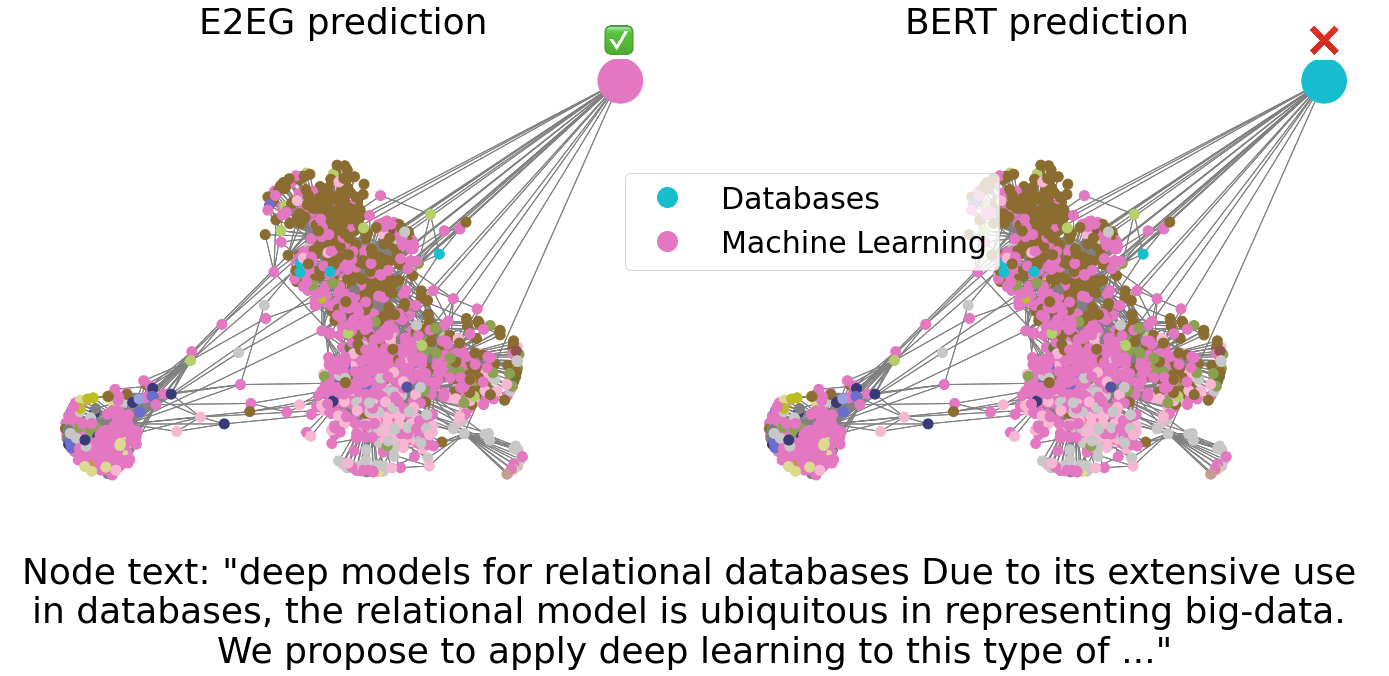

In [11]:
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.rcParams.update({'font.size': 30})

nr_classes = data.y.max().numpy() + 1
cmap1 = cm.get_cmap("tab20b")
cmap2 = cm.get_cmap("tab20")
cmap3 = cm.get_cmap("tab20c")
norm = Normalize(vmin=0, vmax=nr_classes)
d1 = {node_class: cmap1(norm(node_class)) for node_class in range(0, 20)}
d2 = {node_class: cmap2(norm(node_class)) for node_class in range(20, 40)}
d3 = {node_class: cmap3(norm(node_class)) for node_class in range(40, nr_classes)}

color_map_all = {**d1, **d2, **d3}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(f'Node text: \"{" ".join(compare_df.loc[central_node, "X_text"].split()[:10])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[10:20])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[20:30])} ...\"', 
             y=-0.01)
np.random.seed(1)

normal_node_size = 100
node_sizes = np.ones((node_subset.shape[0],) ) * normal_node_size
node_sizes[np.where(node_subset.numpy() == central_node)[0][0]] = normal_node_size*20


color_map_mine = [color_map_all[x] for x in data.y[node_subset.numpy()].numpy().flatten()]
color_map_bert = [color_map_all[x] for x in data.y[node_subset.numpy()].numpy().flatten()]
color_map_bert[np.where(node_subset.numpy() == central_node)[0][0]] = \
        color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "bert_pred"]].index[0]]

center_loc = np.array([1,1])

pos=nx.spring_layout(G)
pos[central_node] = center_loc


nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_mine, ax=ax1)
nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_bert, ax=ax2)
ax1.set_title("E2EG prediction")
ax2.set_title("BERT prediction")

# reading the image
correct = plt.imread('../visualization/analysis/correct.png')
wrong = plt.imread('../visualization/analysis/wrong.png')
# OffsetBox
correct_box = OffsetImage(correct, zoom=0.3)
wrong_box = OffsetImage(wrong, zoom=0.3)

ab = AnnotationBbox(correct_box, center_loc + np.array([0, 0.15]), frameon=False)
ax1.add_artist(ab)

ab = AnnotationBbox(wrong_box, center_loc + np.array([0, 0.15]), frameon=False)
ax2.add_artist(ab)

legend_elements = [Line2D([0], [0], marker='o', color=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "bert_pred"]].index[0]], 
                          label=compare_df.loc[central_node, "bert_pred"],
                          markerfacecolor=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "bert_pred"]].index[0]],
                          markersize=20, linestyle=""),
                  Line2D([0], [0], marker='o', color=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]], 
                          label=compare_df.loc[central_node, "my_pred"],
                          markerfacecolor=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]],
                          markersize=20, linestyle="")]
plt.figlegend(handles=legend_elements, loc=(0.45,0.6))

plt.tight_layout()

# plt.savefig(f"../visualization/analysis/BERTvsE2EG_{data_name}_{central_node}central_{num_hops}hop.pdf",
#            bbox_inches='tight')

### Comments:

Among samples of E2EG right BERT wrong, 72.34% (for arxiv) and 95.46% (for products) is predicted correctly by GIANT --> E2EG is better bc it make use of topology via the neighborhood prediction task, and that E2E performs well due to the multi-task setting and not only because of the expressivity of the BERT component.

The samples: text is misleading or unclear but neighborhood is useful

### E2E vs GIANT + MLP

In [12]:
df = compare_df[result_dict['e2e_correct_giant_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'giant_pred', "bert_pred_correct", 'y_true', "class_freq"]]
df["bert_pred_correct"].value_counts(normalize=True)*100


True     89.344262
False    10.655738
Name: bert_pred_correct, dtype: float64

In [13]:
compare_df[result_dict['e2e_correct_giant_wrong']][["same_neighbor(%)", 'my_pred', 'giant_pred', "bert_pred_correct", 'y_true', "class_freq", 'node_degrees']].head()


,same_neighbor(%),my_pred,giant_pred,bert_pred_correct,y_true,class_freq,node_degrees
3876,0.500000,Computer Vision and Pattern Recognition,Machine Learning,True,Computer Vision and Pattern Recognition,0.161335,2.0
5186,0.611111,Computer Vision and Pattern Recognition,Machine Learning,True,Computer Vision and Pattern Recognition,0.161335,18.0
6423,0.375000,Software Engineering,Cryptography and Security,True,Software Engineering,0.016735,8.0
8987,0.000000,Hardware Architecture,Software Engineering,True,Hardware Architecture,0.002380,1.0
13831,0.000000,Human-Computer Interaction,Computation and Language,True,Human-Computer Interaction,0.009555,2.0


In [14]:
central_node = 68308
sample = compare_df[result_dict['e2e_correct_giant_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'giant_pred', "bert_pred_correct", 'y_true', "class_freq", 'node_degrees']].loc[central_node,]
sample["X_text"] = " ".join(sample["X_text"].split()[:128])
sample

X_text               motion control on bionic eyes a comprehensive review Biology can provide biomimetic components and new control principles for robotics. Developing a robot system equipped with bionic eyes is a difficult but exciting task. Researchers have been studying the control mechanisms of bionic eyes for many years and considerable models are available. In this paper, control model and its implementation on robots for bionic eyes are reviewed, which covers saccade, smooth pursuit, vergence, vestibule-ocular reflex (VOR), optokinetic reflex (OKR) and eye-head coordination. What is more, some problems and possible solutions in the field of bionic eyes are discussed and analyzed. This review paper can be used as a guide for researchers to identify potential research problems and solutions of the bionic eyes' motion control.
same_neighbor(%)                                                                                                                                             

In [15]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx, is_undirected, to_undirected, k_hop_subgraph, subgraph
from collections import defaultdict
import matplotlib.cm as cm
from matplotlib.colors import Normalize

num_hops=2

edge_index = data.edge_index
if not is_undirected(edge_index):
    edge_index = to_undirected(edge_index)
Degree = degree(edge_index[0])
Filtered_idx = torch.where(Degree < 300)[0]

edge_index, _ = subgraph(Filtered_idx, edge_index=edge_index)

node_subset, edge_index, _, _ = k_hop_subgraph(node_idx=central_node,   # torch.tensor(df.index.values),
                                                       num_hops=num_hops,
                                                       edge_index=edge_index)


    
G = nx.MultiGraph()
G.add_nodes_from(list(node_subset.numpy()))
G.add_edges_from([tuple(x) for x in edge_index.t().numpy()])


len(node_subset)

220

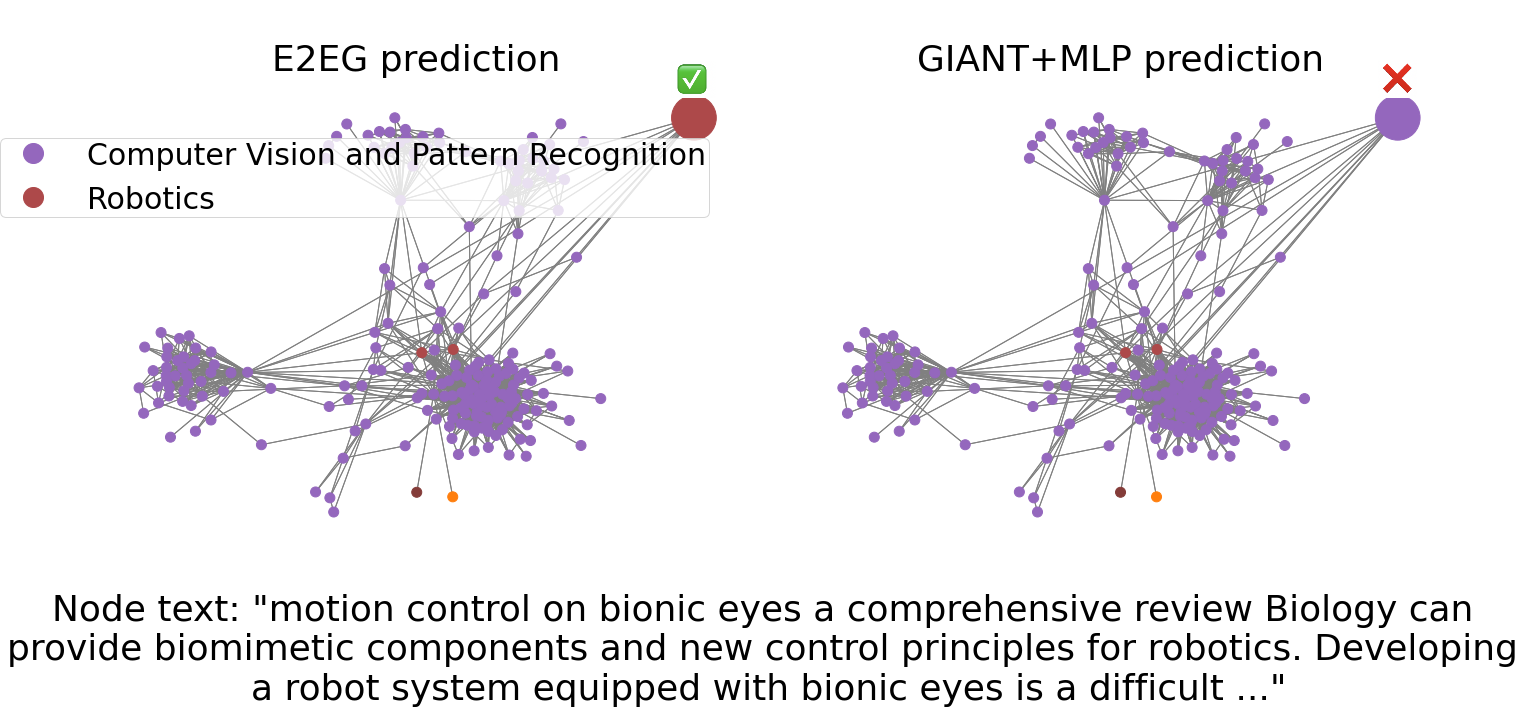

In [17]:
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.rcParams.update({'font.size': 30})

nr_classes = data.y.max().numpy() + 1
cmap1 = cm.get_cmap("tab20")
cmap2 = cm.get_cmap("tab20b")
cmap3 = cm.get_cmap("tab20c")
norm = Normalize(vmin=0, vmax=nr_classes)
d1 = {node_class: cmap1(norm(node_class)) for node_class in range(0, 20)}
d2 = {node_class: cmap2(norm(node_class)) for node_class in range(20, 40)}
d3 = {node_class: cmap3(norm(node_class)) for node_class in range(40, nr_classes)}

color_map_all = {**d1, **d2, **d3}

# data_plot = {'a': np.arange(nr_classes),
#         'b': np.ones((nr_classes)),
#         'c': color_map_all.values(),}

# plt.scatter('a', 'b', c='c', data=data_plot)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(f'Node text: \"{" ".join(compare_df.loc[central_node, "X_text"].split()[:10])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[10:20])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[20:30])} ...\"', 
             y=-0.01)
np.random.seed(300)

normal_node_size = 100
node_sizes = np.ones((node_subset.shape[0],) ) * normal_node_size
node_sizes[np.where(node_subset.numpy() == central_node)[0][0]] = normal_node_size*20


color_map_mine = [color_map_all[x] for x in data.y[node_subset.numpy()].numpy().flatten()]
color_map_giant = [color_map_all[x] for x in data.y[node_subset.numpy()].numpy().flatten()]
color_map_giant[np.where(node_subset.numpy() == central_node)[0][0]] = \
        color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "giant_pred"]].index[0]]

center_loc = np.array([1,1])
pos=nx.spring_layout(G)
pos[central_node] = center_loc

nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_mine, ax=ax1)
nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_giant, ax=ax2)
ax1.set_title("E2EG prediction")
ax2.set_title("GIANT+MLP prediction")

# reading the image
correct = plt.imread('../visualization/analysis/correct.png')
wrong = plt.imread('../visualization/analysis/wrong.png')
# OffsetBox
correct_box = OffsetImage(correct, zoom=0.3)
wrong_box = OffsetImage(wrong, zoom=0.3)

ab = AnnotationBbox(correct_box, center_loc + np.array([0, 0.17]), frameon=False)
ax1.add_artist(ab)

ab = AnnotationBbox(wrong_box, center_loc + np.array([0, 0.17]), frameon=False)
ax2.add_artist(ab)

legend_elements = [Line2D([0], [0], marker='o', color=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "giant_pred"]].index[0]], 
                          label=compare_df.loc[central_node, "giant_pred"],
                          markerfacecolor=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "giant_pred"]].index[0]],
                          markersize=20, linestyle=""),
                  Line2D([0], [0], marker='o', color=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]], 
                          label=compare_df.loc[central_node, "my_pred"],
                          markerfacecolor=color_map_all[map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]],
                          markersize=20, linestyle="")]
plt.figlegend(handles=legend_elements, loc=(0,0.695), borderpad=0.1)

plt.tight_layout()

# plt.savefig(f"../visualization/analysis/GIANTvsE2EG_{data_name}_{central_node}central_{num_hops}hop.pdf",
#            bbox_inches='tight')

### Comments:
Among the nodes where E2E predicts correctly and GIANT predicts wrong, 89.34% (for arxiv) and 94.75% (for products) are correctly predicted by BERT (text only). 

It shows that GIANT's doing worse here due to not being able to embed the text directly under the main objective like BERT and E2E.

Samples where E2E predicts correctly and GIANT predicts wrong: neighborhood misleading or unclear, but text is useful
    

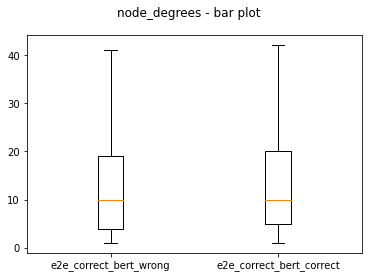

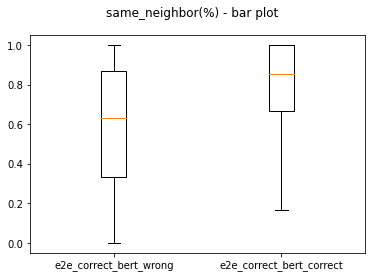

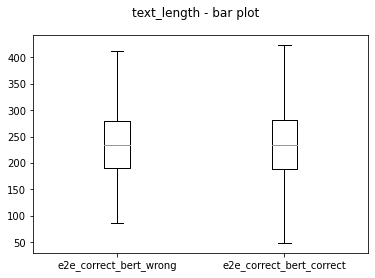

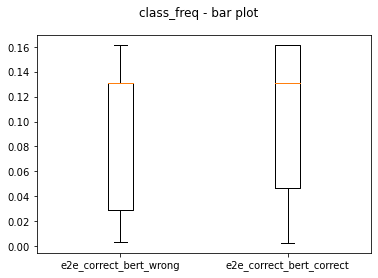

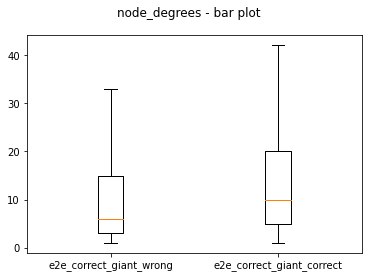

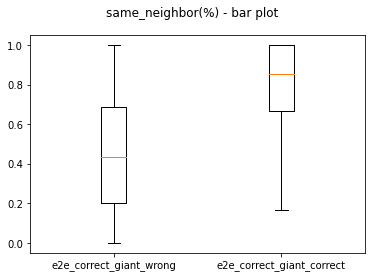

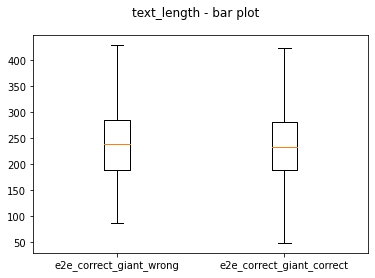

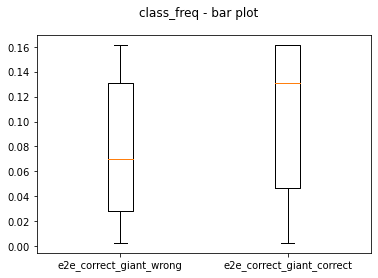

In [92]:
from IPython.display import display
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline  

pd.options.display.float_format = '{:,.2f}'.format

feats = ['node_degrees', "same_neighbor(%)", 'text_length', "class_freq"]
sections = [("e2e_correct_bert_wrong", 'e2e_correct_bert_correct'), ("e2e_correct_giant_wrong", "e2e_correct_giant_correct")]

print_stat = False
plot_stat_hist = False
plot_stat_bar = True
print_shapiro = False  # Test whether the data follows normal distribution
plot_qq = False
print_mannwhitneyu = False  # Test median of the two population
filter_low_class_freq = compare_df["class_freq"] < 0.07 # compare_df["class_freq"].describe()['25%']
compare_df_filtered = compare_df.copy()  # [filter_low_class_freq]


for section in sections:
    for feat in feats:
        if feat in compare_df_filtered.columns:
            if print_stat or print_shapiro or print_mannwhitneyu:
                print(f"{feat}:")
            df = pd.DataFrame({section[0]: compare_df_filtered[result_dict[section[0]]][feat].describe(percentiles=[.01, .25, .5, .75, .99]),
                               section[1]: compare_df_filtered[result_dict[section[1]]][feat].describe(percentiles=[.01, .25, .5, .75, .99])})
            if print_stat:
                display(df)
            if print_shapiro:
                for i in range(0, 2):
                    w, pvalue = stats.shapiro(compare_df_filtered[result_dict[section[i]]][feat])
                    if pvalue < 0.05:
                        print(f"p={pvalue} < 0.05 --> significant --> {feat} of {section[i]} not normally distributed")
            if print_mannwhitneyu:
                # perform two-sided test. You can use 'greater' or 'less' for one-sided test
                result = stats.mannwhitneyu(x=compare_df_filtered[result_dict[section[0]]][feat], 
                                   y=compare_df_filtered[result_dict[section[1]]][feat], 
                                   alternative = 'two-sided')
                print(result)
                print(type(result))
            if plot_qq:
#                 fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
#                 fig.suptitle(f"{feat} - qqplot")
                plt.figure()
                for i in range(0,2):
                    sm.qqplot(compare_df_filtered[result_dict[section[i]]][feat], line ='45')
                    plt.title(section[i] + section[i] + "qqplot")
            if plot_stat_hist:
                fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
                fig.suptitle(f"{feat} - density plot")
                for i in range(0,2):
                    axs[i].hist(compare_df_filtered[result_dict[section[i]]][feat], 
                                bins=100, 
                                range=(df[section[i]]['min'], 
                                       df[section[i]]['99%']),
                                density=True)
                    axs[i].set_title(section[i])
            if plot_stat_bar:
                fig, ax = plt.subplots()
                my_dict = {section[0]: compare_df_filtered[result_dict[section[0]]][feat],
                           section[1]: compare_df_filtered[result_dict[section[1]]][feat]}
                ax.boxplot(my_dict.values(), showfliers=False)
                ax.set_xticklabels(my_dict.keys())
                fig.suptitle(f"{feat} - bar plot")
            if print_stat or print_shapiro or print_mannwhitneyu:
                print("-------------------------------------------------")

### Statistical test to compare the two 
Use nonparametric tests (distribution is not normal, from desity plot, shapiro and qq-plot). But number of samples is too high --> always reject --> not reliable.
Just look at the box plot then.

### Arxiv

- `e2e_correct_bert_wrong` vs `e2e_correct_bert_correct`: 
    - `node_degrees` slighly lower --> counter intuitive --> nodes with more neighbors also have better text description?
    - `same_neighbor(%)` lower --> counter intuitive --> nodes with more similar neighbors also have better text description?
    - `text_length`: slighly higher --> counter intuitive --> ????
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
    
    

- `e2e_correct_giant_wrong` vs `e2e_correct_giant_correct`: 
    - `node_degrees`: slighly lower 
    - `same_neighbor(%)`: lower
    - `text_length`: higher
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
    
    
But when avg over runs, no clear difference really, except for `class_freq`


### Products
- `e2e_correct_bert_wrong` vs `e2e_correct_bert_correct`: 
    - `node_degrees`: similar
    - `same_neighbor(%)` lower --> counter intuitive --> nodes with more similar neighbors also have better text description?
    - `text_length`: slighly lower --> doesnt say much
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
    
    

- `e2e_correct_giant_wrong` vs `e2e_correct_giant_correct`: 
    - `node_degrees`: similar 
    - `same_neighbor(%)`: lower
    - `text_length`: slighly lower --> doesnt say much
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
